In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from sys import path
path.insert(0, "lib")
#from minima import *
from colorline import colorline

%load_ext autoreload
%autoreload 2

In [29]:
class Langevin:
    """
    Langevin dynamics approximating SGD on a 2D model
    """
    def __init__(self, lr, q, grad_q, mxx, std_xx, std_xy, w_init, seed):
        """
        lr: learning rate
        q: model
        grad_q: gradient of the model
        mxx: expected value of X^2
        vxx: Var(X^2)
        vxy: Var(XY)
        """
        self.lr = lr
        self.q = q
        self.grad_q = grad_q
        self.mxx = mxx
        self.std_xx = std_xx
        self.std_xy = std_xy
        self.w_init = w_init
        self.w = [self.w_init]
        self.state = np.random.RandomState(seed=seed)
        
    def update(self, w_old,d1,d2,c):
        xi_xx = self.state.normal(self.mxx, self.std_xx)
        xi_xy = self.state.normal(0.0, self.std_xy)
        return w_old - self.lr*(xi_xx * self.q(w_old,d1,d2,c) - xi_xy) * self.grad_q(w_old,d1,d2,c)
    
    def evolve(self, nstep,d1,d2,c):
        wc = self.w[-1]
        for _ in range(nstep):
            wc = self.update(wc,d1,d2,c)
            self.w.append(wc)

In [30]:
# Plotting settings
plt.style.use('ggplot')
fig_width = 25  # figure width in cm
inches_per_cm = 0.393701               # Convert cm to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width*inches_per_cm  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
label_size = 14
tick_size = 12
params = {'backend': 'ps',
          'lines.linewidth': 1.5,
          'axes.labelsize': label_size,
          'axes.titlesize': label_size,
          'font.size': label_size,
          'legend.fontsize': tick_size,
          'xtick.labelsize': tick_size,
          'ytick.labelsize': tick_size,
          'text.usetex': False,
          'figure.figsize': fig_size,
          "font.weight": "bold",
          "axes.labelweight": "bold"}
plt.rcParams.update(params)

In [35]:
def q(w,d1,d2,c):
    w1, w2 = w
    return (w1 - c)**d1*(w1**d2 + w2**d2)
    
def grad_q(w, d1, d2, c):
    w1, w2 = w
    partial_w1 = d2 * w1**(-1 + d2) * (w1 - c)**d1 + d1 * (w1 - c)**(-1 + d1) * (w1**d2 + w2**d2)
    partial_w2 = d2 * (w1 - c)**d1 * w2**(-1 + d2)
    return np.array([partial_w1, partial_w2])

d1=2
d2=2
c=0
lr = 0.01
mxx = 1.
std_xx = 1.
std_xy = 1.
wiy = -0.4
wmx = 0.5
num_trajectories = 1
nsteps = 10**6
trajectories = []
for i in range(num_trajectories):
    seed = i
    #wix = np.random.uniform(-wmx, wmx)
    wix = -0.1
    w_init = np.array([wix, wiy])
    L = Langevin(lr, q, grad_q, mxx, std_xx, std_xy, w_init, seed)
    L.evolve(nsteps,d1,d2,c)
    trajectories.append(np.array(L.w).T)

trajectories = np.asarray(trajectories)

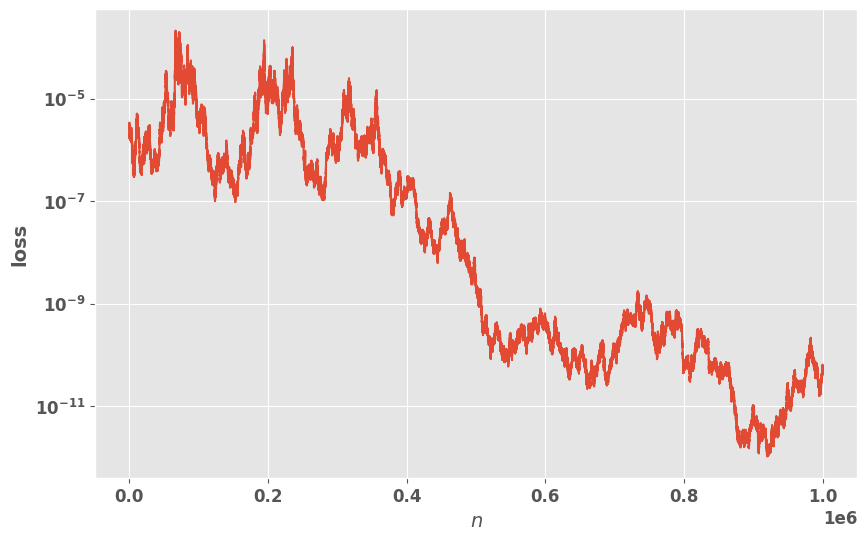

In [41]:
fig, ax = plt.subplots()
plt.plot(L.q(np.array(L.w).T**2,d1,d2,c))
ax.set_yscale('log')
# ax.set_xscale('log')
plt.xlabel(r'$n$')
plt.ylabel('loss')
#plt.savefig('2d_loss.png', dpi=150)
plt.show()

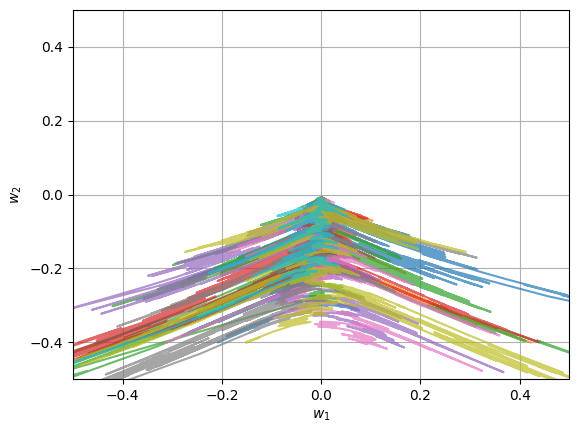

In [20]:
fig, ax = plt.subplots()
for i in range(num_trajectories):
    w = trajectories[i,:,:]
    #x, y = np.array(L.w).T
    plt.plot(w[0,:], w[1,:], label=f'Trajectory {i+1}', alpha=0.7)
    #z = np.linspace(0, 1, len(x))
    #colorline(ax, x, y, z, cmap=plt.get_cmap('viridis'), linewidth=2)
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.xlim((-wmx, wmx))
plt.ylim((-wmx, wmx))
plt.grid(True)
plt.show()

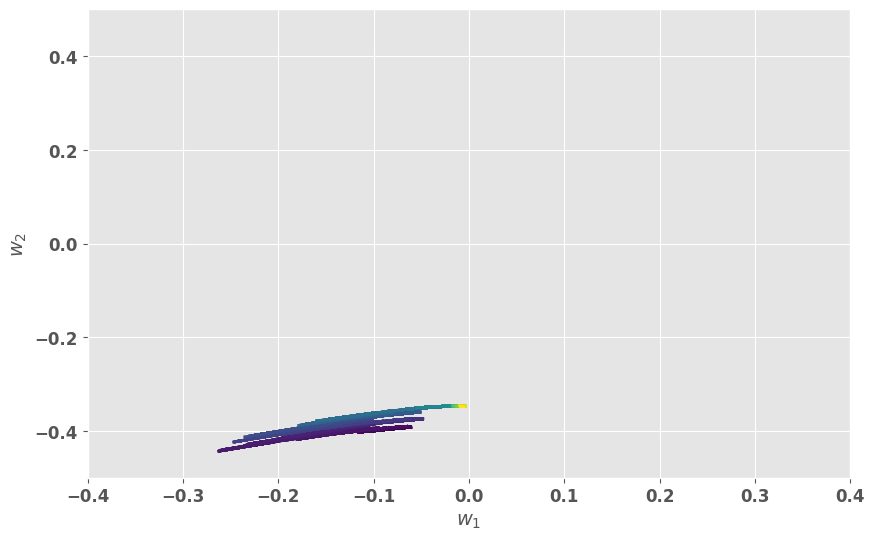

In [37]:
fig, ax = plt.subplots()
w = trajectories[0,:,:]
x, y = np.array(L.w).T
z = np.linspace(0, 1, len(x))
colorline(ax, x, y, z, cmap=plt.get_cmap('viridis'), linewidth=2)
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.xlim((-0.4, 0.4))
plt.ylim((-wmx, wmx))
plt.grid(True)
plt.show()

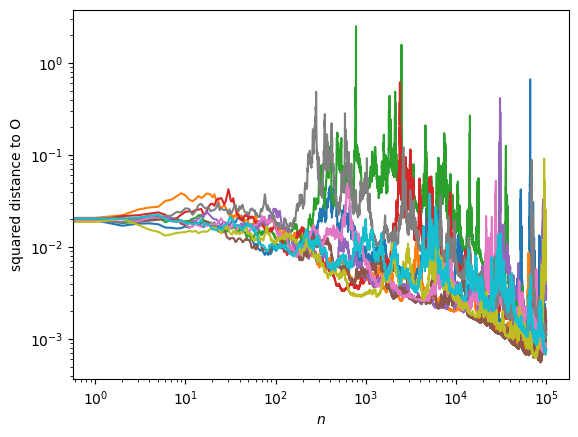

In [218]:
def q(w):
    w1, w2 = w
    return w1*(w1*w1 + w2*w2)
    
def grad_q(w):
    w1, w2 = w
    return np.array([3*w1*w1 + w2*w2, 2*w1*w2])

lr = 0.1
mxx = 1.
std_xx = 1.
std_xy = 1.
w_init = np.array([-0.1, -0.1])
fig, ax = plt.subplots()
for seed in range(10):
    L = Langevin(lr, q, grad_q, mxx, std_xx, std_xy, w_init, seed)
    L.evolve(100000)
#     plt.plot(*np.array(L.w).T)
    sq_dist = np.sum(np.array(L.w)**2., axis=1)
    plt.plot(sq_dist)
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylabel('squared distance to O')
plt.xlabel('$n$')
plt.savefig("2d_sq_dist.png", dpi=150)
plt.show()